 В файле `D_4(Обучение ARIMA)` мы подробно разобрали как работает этот алгоритм, в этом же файле мы посмотрим, как с помощью подобраной модели `ARIMA` нам удастся сделать прогноз.

In [1]:
%pylab inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('нефть-brent-2010-2019.csv', index_col=[0], parse_dates=[0])
data.head()

,value
date,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


In [3]:
data.describe()

,value
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


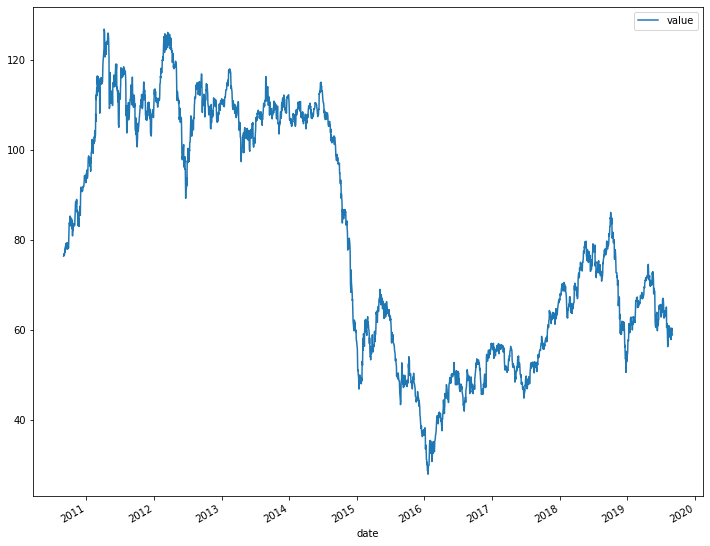

In [4]:
data.plot()

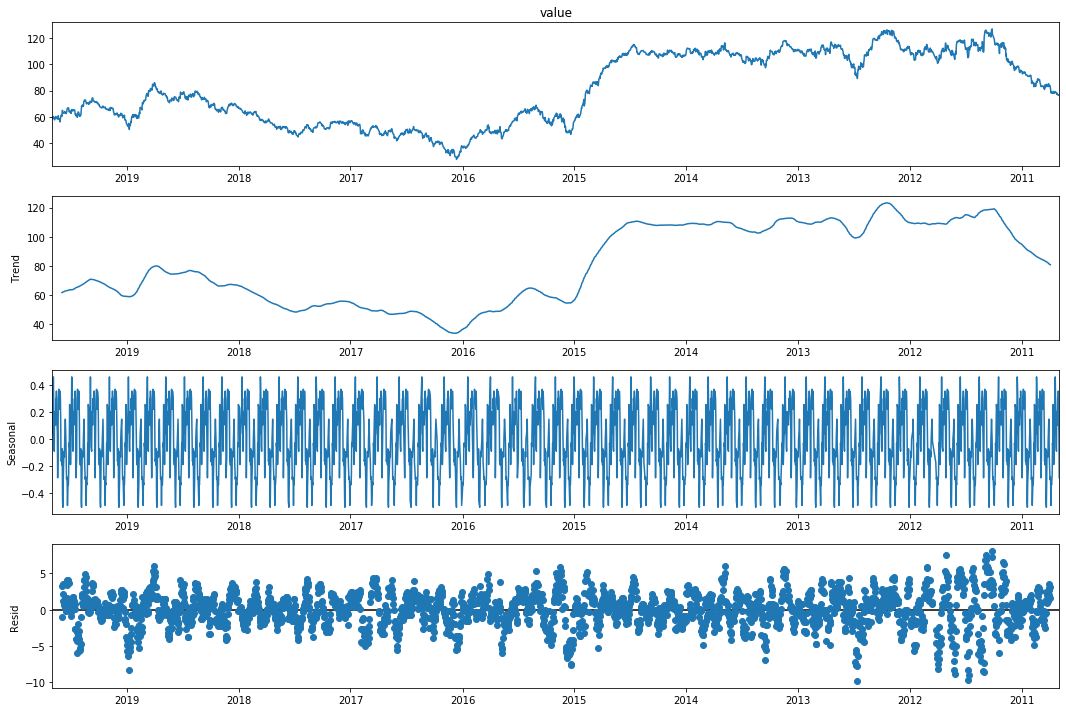

<Figure size 1080x720 with 0 Axes>

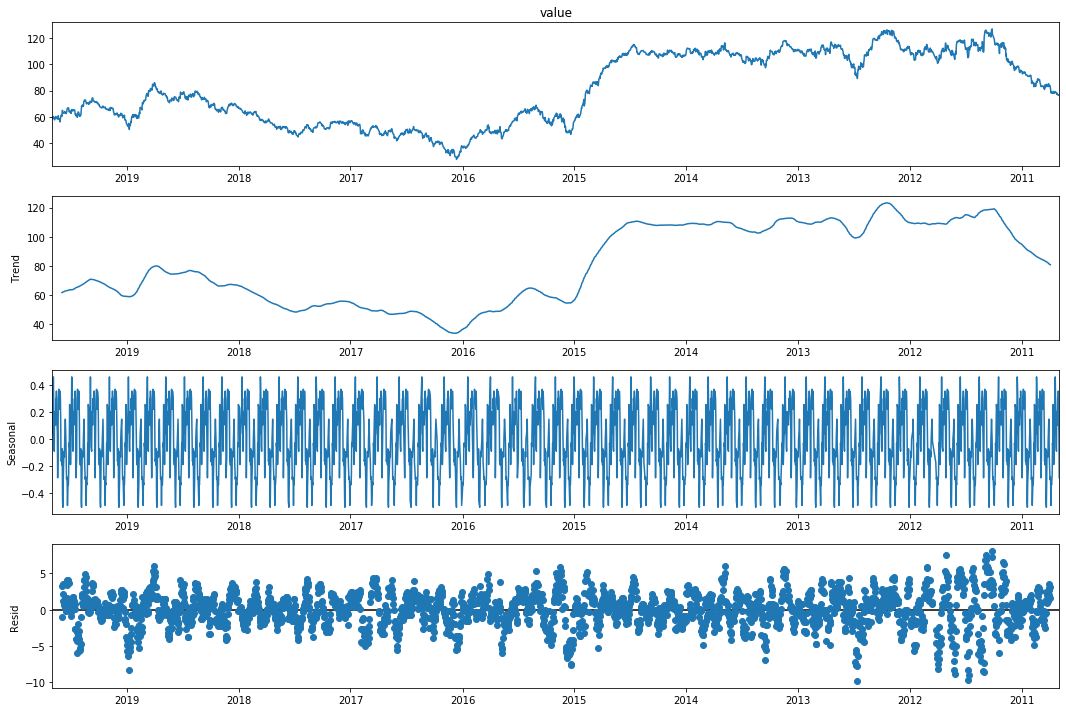

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.value, freq=52).plot()

На данных графиках мы видим явную сезонность и тренд, которые подтверждают гипотезу о нестационарности рядя.

Сделаем ресемплинг по месяцам.

In [6]:
data_m = data.resample('MS').mean()
data_m.tail()

,value
date,
2019-05-01,69.966667
2019-06-01,62.980400
2019-07-01,64.292963
2019-08-01,59.263077
2019-09-01,58.840000


Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.689912


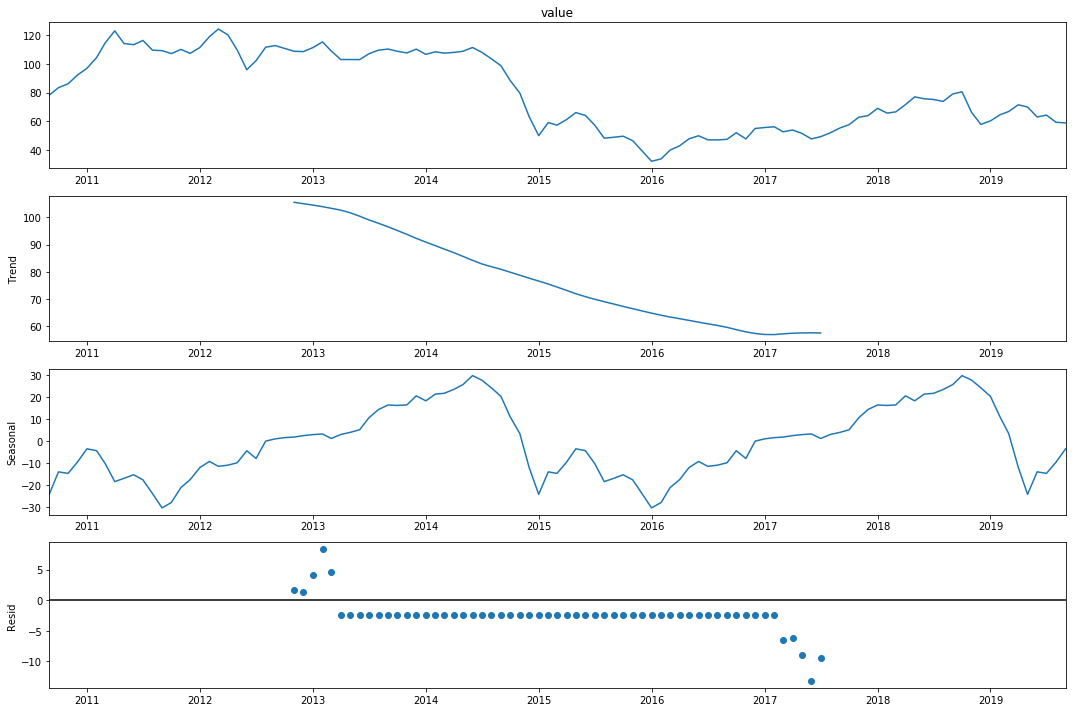

In [7]:
sm.tsa.seasonal_decompose(data_m['value'],freq=52).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['value'])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, но есть тренд и сезонность, также мы видим нестационарность в графике с остатками. 

`Попробуем сезонное дифференцирование`; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.171834


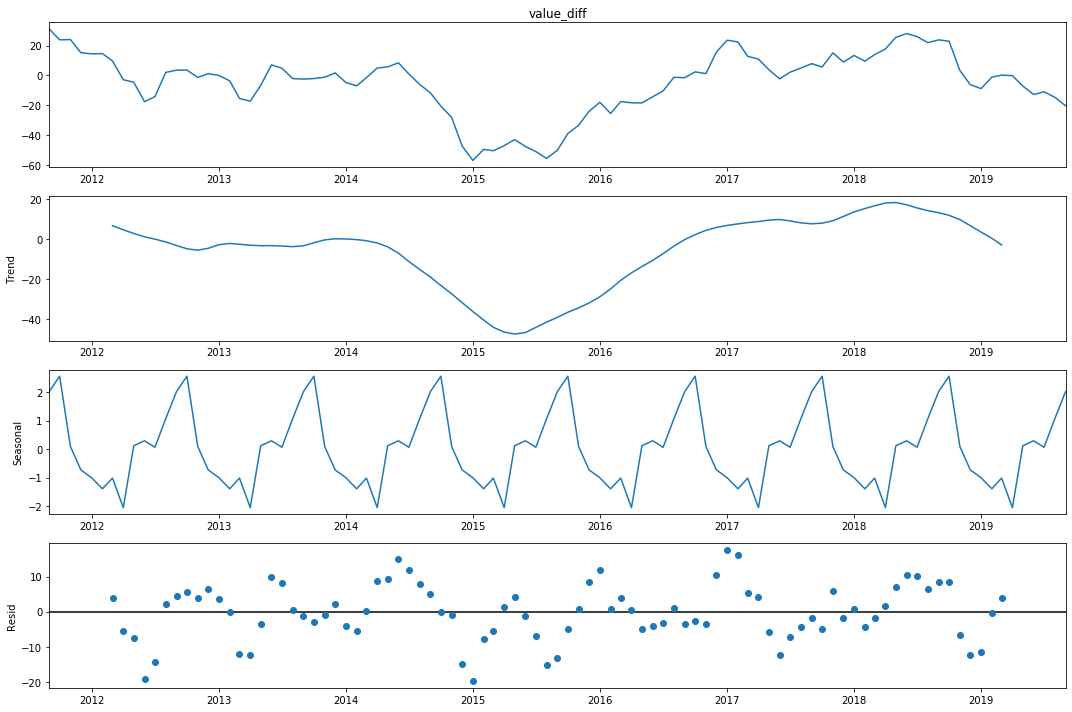

In [8]:
data_m['value_diff'] = data_m['value'] - data_m['value'].shift(12)
sm.tsa.seasonal_decompose(data_m['value_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['value_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, остатки стали лучше, по графикам видно, что остался `тренд`. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


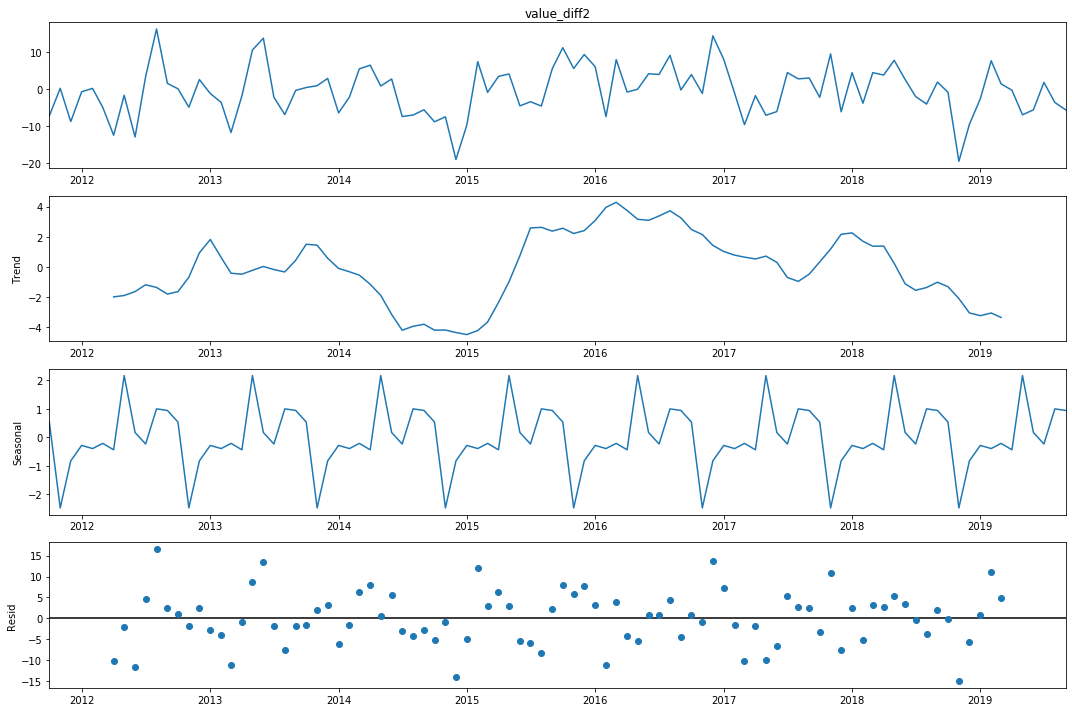

In [9]:
data_m['value_diff2'] = data_m['value_diff'] - data_m['value_diff'].shift(1)
sm.tsa.seasonal_decompose(data_m['value_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['value_diff2'][13:])[1])

Гипотеза о нестационарности отвергается, тренда нет, остатки выглядят как белый шум, также ее отвергает показатель Критерии Дики-Фуллера.

## Постоение модели временного ряда

Параметр **d** есть и он равет 1, осталось определить **p** и **q**. Для их определения нам надо изучить авторкорреляционную`(ACF)` и частично автокорреляционную`(PACF)` функции для ряда первых разностей.
1. `ACF` поможет нам определить **q**, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
2. `PACF` поможет нам определить **p**, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

Посмотрим на `Автокорреляционную функцию` и `Частичную автокорреляцию`

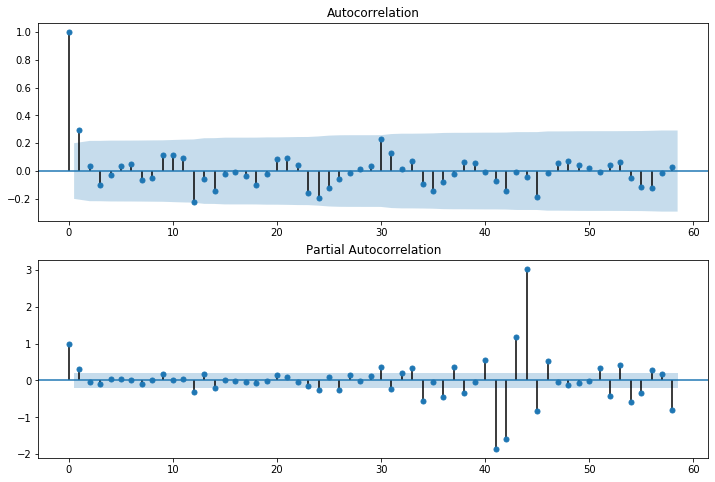

In [85]:
plt.figure(figsize=(12,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_m['value_diff2'][13:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_m['value_diff2'][13:].values.squeeze(), lags=58, ax=ax);

После изучения коррелограммы `PACF` можно сделать вывод, что `p = 7`, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что `q = 1`, т.к. после лага 1 значении функций резко падают.

Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [10]:
ps = range(0,7)
d=1
qs = range(0, 1)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

35

Построим модель `ARIMA`

In [12]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_m['value'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 31.9 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
8   (1, 0, 3, 0)  618.047130
9   (1, 0, 4, 0)  618.128281
13  (2, 0, 3, 0)  619.503973
14  (2, 0, 4, 0)  619.554378
7   (1, 0, 2, 0)  619.809435


Посмотрим на лучшую модель:

In [14]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -304.024
Date:                            Fri, 03 Apr 2020   AIC                            618.047
Time:                                    17:10:55   BIC                            630.869
Sample:                                09-01-2010   HQIC                           623.230
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3194      0.100      3.205      0.001       0.124       0.515
ar.S.L12      -0.5091      0.133   

Остатки

Критерий Стьюдента: p=0.412458
Критерий Дики-Фуллера: p=0.000000


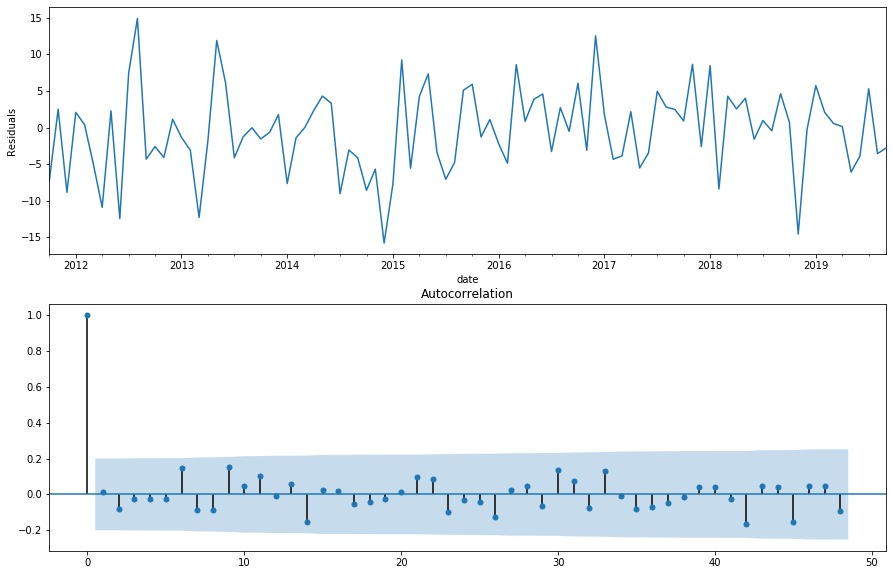

In [15]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы. 

Посмотрим, насколько хорошо модель описывает данные:

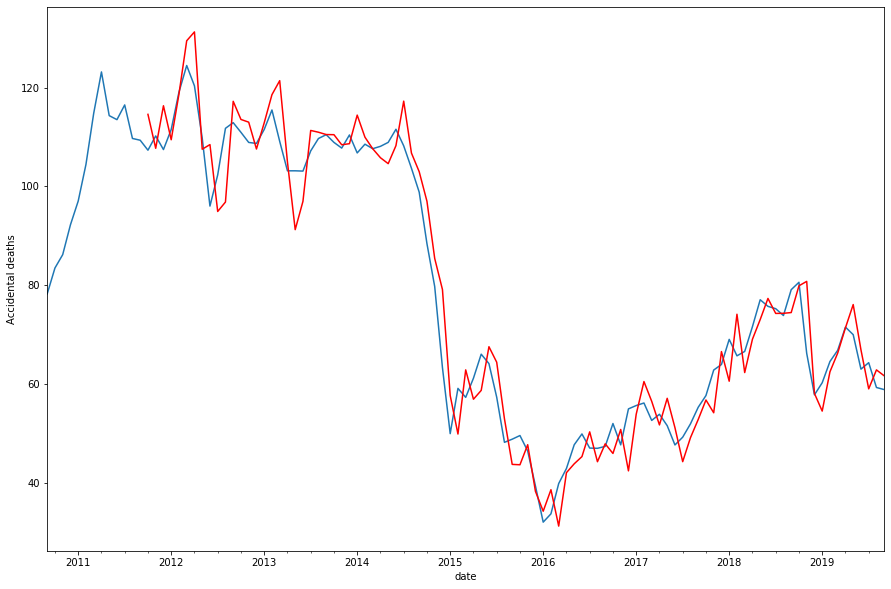

In [16]:
data_m['model'] = best_model.fittedvalues
data_m['value'].plot()
data_m['model'][13:].plot(color='r')
plt.ylabel('Accidental deaths');

Видно, что есть небольшие пики расхождения, но модель достаточно хорошо описывает данные и на основе этих данных можно сделать прогноз на будущее.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


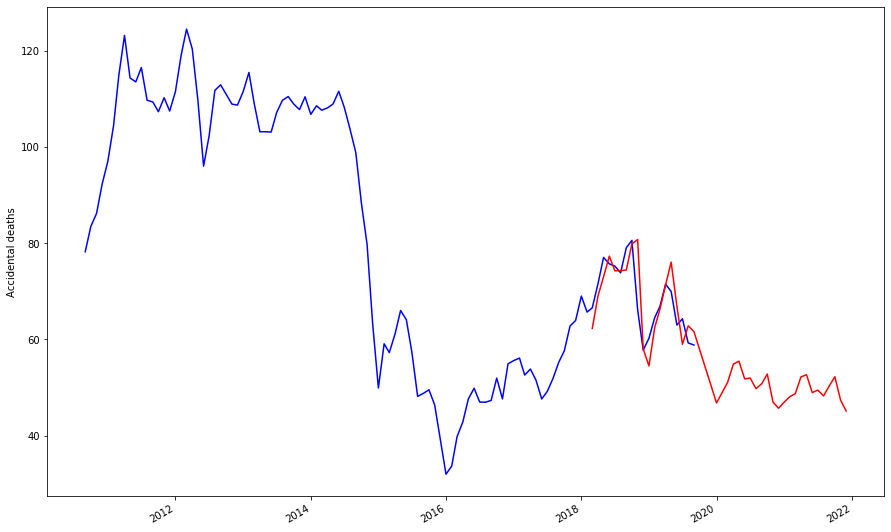

In [17]:
from dateutil.relativedelta import relativedelta
deaths2 = data_m[['value']]
date_list = [pd.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=90, end=160)

deaths2['value'].plot(color='b')
deaths2['forecast'].plot(color='r')
plt.ylabel('Accidental deaths');

`Вывод:` Мы применили обучение ARIMA (SARIMA), нашли для данных лучшую модель, которая хорошо описывает исходные данные.

На основе этого сделали прогноз цен на нефть в ближайшие `2 года`.
По графику видно, что цены на нефть будут медленно `падать`.